# Tasks:
1) Conduct an EDA
2) Handle null-values
3) Visualize data
4) build and score baseline models for logistic regression and SVM

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.pipeline import make_pipeline  # используем пайплайны для удобства
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score as acc, precision_recall_fscore_support as prf

In [4]:
data = pd.read_csv('adult.csv', na_values='?')

# EDA

In [5]:
data.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


# Handle null-values

* Let's just keep it simple and delete all nulls which are about 7%

* "Education" corresponds to "educational-num", let's leave it behind

In [7]:
data = data[~data['workclass'].isna()]
data = data[~data['occupation'].isna()]
data.loc[data['native-country'].isna(), 'native-country'] = 'United-States'
data = data.drop('educational-num', axis=1)

# Visualize

In [93]:
class dfWorking:
    def __init__(self, data):
        self.data = data
        
    def plotter(self, criteria, label, plt_type=plt.hist):
        plt.figure(figsize=(10, 4))
        
        for inc, col in zip(('<=50K', '>50K'), ('b', 'r')):
            dat = data[data['income'] == inc][criteria]
            plt_type(dat, color=col, label=inc, histtype='bar', align='mid')
        
        plt.title(label)
        plt.ylabel('quantity, ppl')
        plt.xlabel(criteria)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
workClass = dfWorking(data)

### Age / income

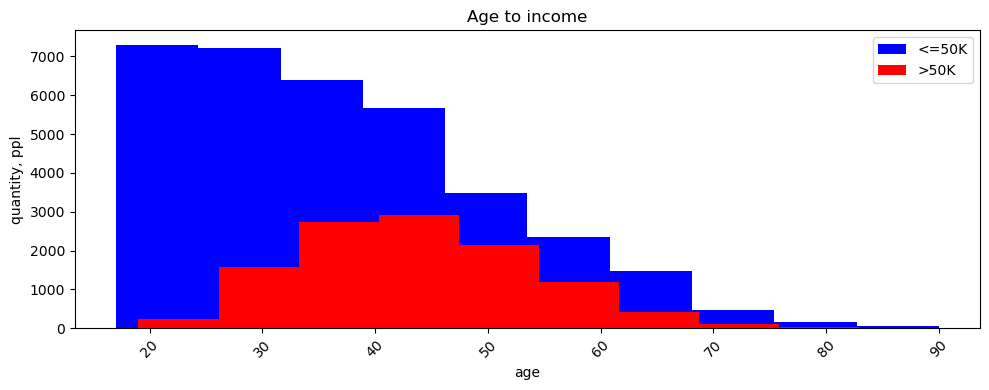

In [96]:
workClass.plotter('age', 'Age to income')

### Gender / income

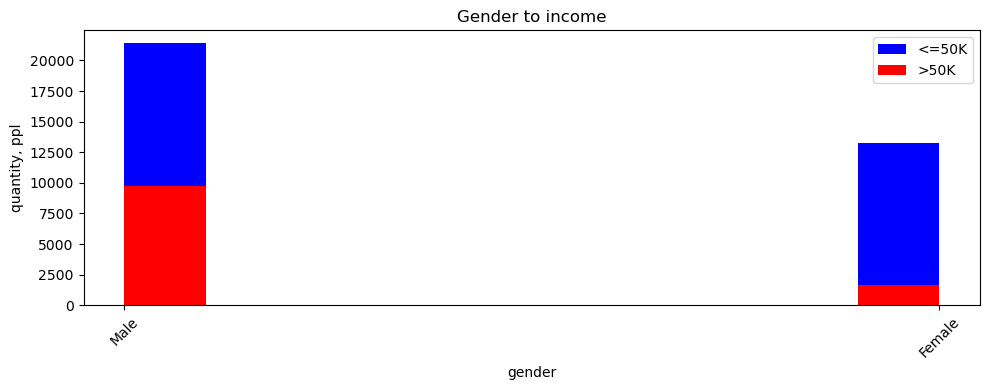

In [97]:
workClass.plotter('gender', 'Gender to income')

### Race / Income

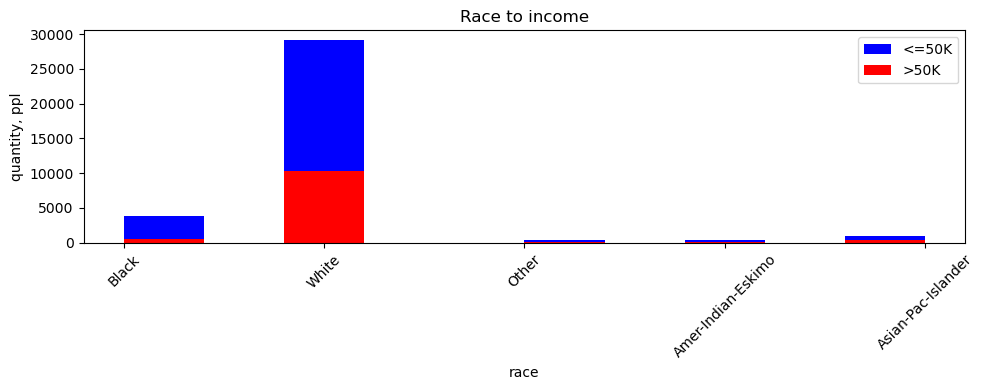

In [98]:
workClass.plotter('race', 'Race to income')

### Marital status / income

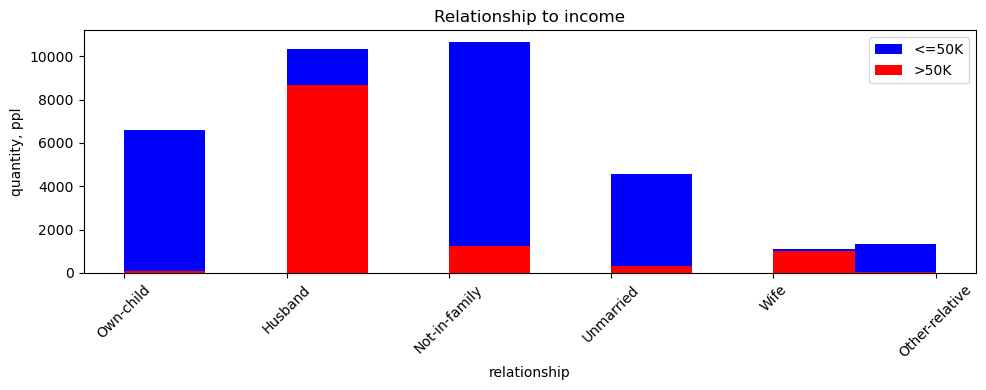

In [99]:
workClass.plotter('relationship', 'Relationship to income')

### Occupation / income

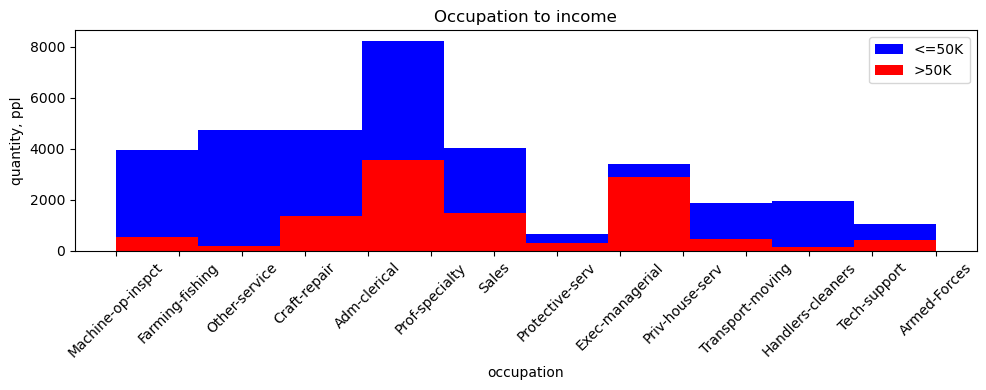

In [100]:
workClass.plotter('occupation', 'Occupation to income')

### Education / income

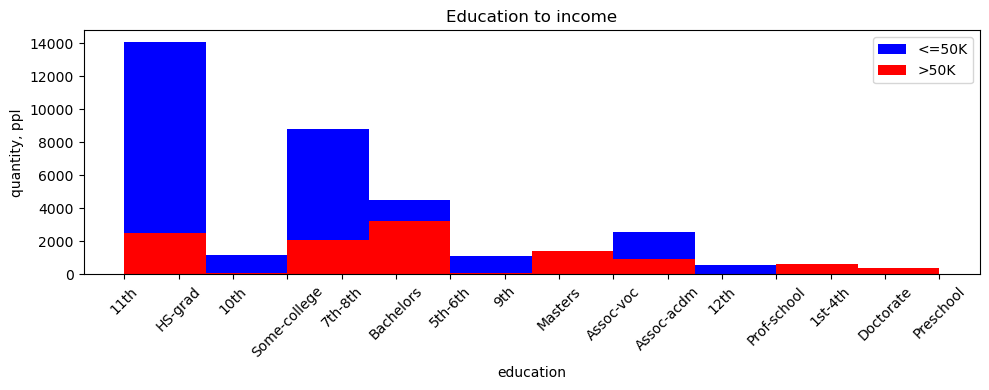

In [101]:
workClass.plotter('education', 'Education to income')

# Prepocessing

### Working with categotical

In [102]:
selectCols = data[['age', 'capital-gain', 'race',  'gender', 'marital-status', 'occupation', 'education']]

In [103]:
X = pd.get_dummies(selectCols, columns = ['race', 'gender', 'marital-status', 'occupation', 'education'])

X.head()

,age,capital-gain,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male,marital-status_Divorced,...,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college
0,25,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,38,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,28,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,44,7688,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,34,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
y = pd.Series(data=LabelEncoder().fit_transform(data['income']))
y.head()

0    0
1    0
2    1
3    1
4    0
dtype: int32

### Baseline logistic regression

In [164]:
class trainAndScore:
    def __init__(self, X, y, model):
        self.X, self.y = X, y
        self.model = model
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
    def score(self):
        pipe_model = make_pipeline(
            StandardScaler(),
            self.model()
        )
        
        pipe_model.fit(self.X_train, self.y_train)
        yhat = pipe_model.predict(self.X_test)
        
        print(f'Accuracy: {acc(self.y_test, yhat)}')
        
        for score, val in zip(('precision', 'recall', 'f1score'), prf(self.y_test, yhat)[:-1]):
            print(f'{score}: {val[1]}')
        
        # print(*prf(self.y_test, yhat)[:-1], sep='\n')

In [165]:
trainAndScore(X, y, LogisticRegression).score()

Accuracy: 0.8394641564083997
precision: 0.7217015140591204
recall: 0.580794894110821
f1score: 0.6436264266195145


### Baseline SVM

In [167]:
trainAndScore(X, y, SVC).score()

Accuracy: 0.8401158580738595
precision: 0.7328072153325818
recall: 0.5657093124456049
f1score: 0.6385068762278977
